# Lasso regression

Given $x_1,...,x_n \in \mathbb{R}^d$ data vectors and $y_1,...,y_n \in \mathbb{R}$ observations, we are searching for regression parameters $w \in \mathbb{R}^d$ which fit data inputs to observations $y$ by minimizing their squared difference. In a high dimensional setting (when $n \ll d$) a $l_1$ norm penalty is
often used on the regression coefficients $w$ in order to enforce sparsity of the solution (so
that $w$ will only have a few non-zeros entries). Such penalization has well known statistical
properties, and makes the model both more interpretable, and faster at test time.

From an optimization point of view we want to solve the following problem called LASSO
(which stands for Least Absolute Shrinkage Operator and Selection Operator)

<center>minimize $\frac{1}{2}||Xw - y||_2^2  + \lambda ||w||_1$</center>
    
in the variable $w \in \mathbb{R}$, where $X = (x_1^T,...,x_n^T) \in \mathbb{R}^{n \times d}$, $y = (y_1,...,y_n) \in \mathbb{R}^n$ and $\lambda > 0$ is a regularization parameter.

## Exercise 1

Derive the dual problem of LASSO and format it as a general Quadratic Problem as follows

<center>minimize $v^TQv + p^Tv$</center>
<center>subject to $Av \preceq b$</center>

in variable $v \in \mathbb{R}^n$, where $Q \succeq 0$.

**Solution:** the Lasso problem described above has the following dual problem:

<center>minimize $v^Tv + 2y^Tv$</center>
<center>subject to $X^Tv \preceq 1$ and $X^Tv \succeq -1$</center>

which is equivalent to

<center>minimize $v^Tv + 2y^Tv$</center>
<center>subject to $[X, -X]^Tv \preceq \lambda$</center>

The handwritten computations are shown in the photo below:

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

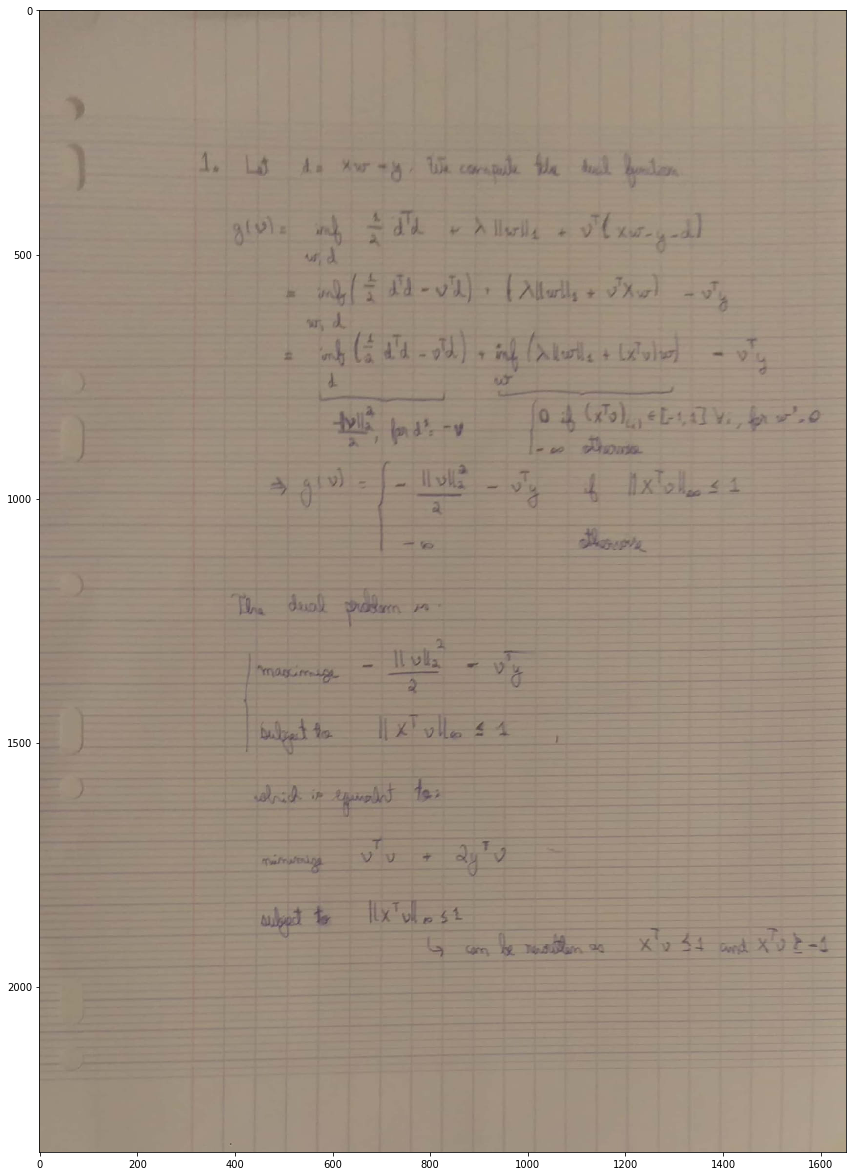

In [3]:
exercise_1_path = 'Exercise 1 - Homework 3 - Convex Optimization - MVA.jpg'
plt.figure(figsize=(28,21))
plt.imshow(plt.imread(exercise_1_path))

## Exercise 2

Implement the barrier method to solve $QP$.

- Write a function ```v_seq = centering_step(Q,p,A,b,t,v_0,eps)``` which implements the Newton method to solve the centering step given the inputs ($Q$,$p$,$A$,$b$), the barrier method parameter $t$ (see lectures), initial variable $v_0$ and a target precision $\epsilon$. The function outputs the sequence of variables iterates $(v_i)_{i=1...n(\epsilon)}$, where $n(\epsilon)$ is the number of iterations to obtain the $\epsilon$ precision.  Use a backtracking line search with appropriate parameters.

- Write a function ```v_seq = barr_method(Q,p,A,b,v0,eps)``` which implements the barrier method to solve QP using precedent function given the data inputs ($Q$,$p$,$A$,$b$), a feasible point $v_0$, a precision criterion $\epsilon$.  The function outputs the sequence of variables iterates $(v_i)_{i=1,...,n_{\epsilon}}$, where $n_{\epsilon}$ is the number of iterations to obtain the $\epsilon$ precision.

In [74]:
import numpy as np

In [134]:
class Differentiator:
    def __init__(self, Q, p, A, b, t, eps):
        self.Q, self.p, self.A, self.b, self.t, self.eps = Q, p, A, b, t, eps

    def standard_loss(self, v):
        return (np.matrix(v) * np.matrix(self.Q) * np.matrix(v).T + np.matrix(self.p) * np.matrix(v).T).item(0, 0)

    def phi_i(self, v, i):
        return np.dot(self.A[i], np.squeeze(v)) - self.b[i]
    
    def phi_loss(self, v):
        return np.sum([-np.log(-self.phi_i(v, i)) for i in range(len(self.A))])
        
    def t_loss(self, v):
        return self.t * self.standard_loss(v) + self.phi_loss(v)
    
    def standard_gradient(self, v):
        return 2 * np.dot(self.Q, v) + self.p

    def phi_gradient(self, v):
        return np.sum([-1/self.phi_i(v, i) * A[i].T for i in range(len(self.A))], axis=0)
    
    def t_gradient(self, v):
        return self.t * self.standard_gradient(v) + self.phi_gradient(v)

    def standard_hessian(self, v):
        return 2 * self.Q
    
    def phi_hessian(self, v):
        phi_is = [self.phi_i(v, i) for i in range(len(self.A))]
        return np.sum([1/phi_is[i]**2 * np.array(np.matrix(A[i]).T * np.matrix(A[i]))  for i in range(len(self.A))], axis=0)
    
    def t_hessian(self, v):
        return self.t * self.standard_hessian(v) + self.phi_hessian(v)


def line_search(v, step, solver, t0=1., alpha=0.25, beta=0.9):
    print('Performing linear search:')
    t = t0
    while solver.t_loss(v + t * step) > solver.t_loss(v) + alpha * t * np.dot(solver.t_gradient(v).T, step):
        print('{} > {} + {}'.format(solver.t_loss(v + t * step), solver.t_loss(v), alpha * t * np.dot(solver.t_gradient(v).T, step)))
        t = t * beta
    return v + t * step

def centering_step(Q, p, A, b, t, v0, eps):
    print('Centering step:')
    solver = Differentiator(Q, p, A, b, t, eps)
    v = v0
    while True:
        grad, hessian = np.matrix(solver.t_gradient(v)).T, np.matrix(solver.t_hessian(v))
        newton_step = -np.linalg.inv(hessian) * grad
        squared_newton_decrement = (- grad.T * newton_step).item(0, 0)
        newton_step = newton_step.getA().T[0]
        
        print('squared newton decrement: ')
        print(squared_newton_decrement)

        if squared_newton_decrement < 2 * eps:
            break
        v = line_search(v, newton_step, solver)
    return v


def barr_method(Q, p, A, b, v0, eps, mu=2):
    t = 0.1
    v = v0
    while True:
        v = centering_step(Q, p, A, b, t, v, eps)
        if t > len(A)/eps:
            break
        t = mu * t
    return v, t

## Exercise 3

Test your function on randomly generated matrices $X$ and observations $y$ with $\lambda = 10$. Plot precision criterion and gap $f(v_t) - f^*$ in semilog scale (using the best value found for $f$ as a surrogate for $f^∗$). Repeat for different values of the barrier method parameter $\mu = 2, 15, 50, 100,...$ and check the impact on $w$.  What would be an appropriate choice for $\mu$?

### Generating the data

In [135]:
def generate(n, d, eps = 0.01):
    X = np.random.randn(d, n)
    w = np.random.randn(1, d)
    errors = np.random.randn(1, n)
    y = (np.matmul(w, X) + errors > 0)
    
    return X, y, w

In [136]:
n, d = 2, 3

In [137]:
X, y, truth_w = generate(n, d)

### Construct the dual problem

In [138]:
Q = np.identity(n)
p = 2 * y[0]
A = np.concatenate((X, -X))
b = np.ones(2 * d)
v0 = np.zeros(n)
eps = 1e-5

### Find the optimal solution for the dual problem

In [139]:
hat_v, hat_t = barr_method(Q, p, A, b, v0, eps, mu=2)

Centering step:
squared newton decrement: 
0.048186199034392564
Performing linear search:
squared newton decrement: 
7.66509744340163e-06
Centering step:
squared newton decrement: 
0.0202329109495619
Performing linear search:
squared newton decrement: 
8.78423778071091e-06
Centering step:
squared newton decrement: 
0.03728510080470944
Performing linear search:
squared newton decrement: 
2.597806198378234e-05
Performing linear search:
squared newton decrement: 
2.6191419207640568e-11
Centering step:
squared newton decrement: 
0.052968119611282324
Performing linear search:
squared newton decrement: 
2.7315628240778978e-05
Performing linear search:
squared newton decrement: 
1.7047821272058066e-11
Centering step:
squared newton decrement: 
0.05776764125585186
Performing linear search:
squared newton decrement: 
9.031547341097701e-06
Centering step:
squared newton decrement: 
0.05511228628528524
Performing linear search:
squared newton decrement: 
6.460368537853656e-06
Centering step:
squa

In [140]:
t = 1000
solver = Differentiator(Q, p, A, b, t, eps)
self = solver

In [141]:
solver.phi_i(v0, 1)

-1.0

In [142]:
self.b.shape

(6,)

In [143]:
self.A.shape

(6, 2)

In [157]:
A, X

(array([[-0.38303094, -1.58395318],
        [-0.41452117,  0.60919216],
        [-0.66847649, -2.619739  ],
        [ 0.38303094,  1.58395318],
        [ 0.41452117, -0.60919216],
        [ 0.66847649,  2.619739  ]]), array([[-0.38303094, -1.58395318],
        [-0.41452117,  0.60919216],
        [-0.66847649, -2.619739  ]]))

In [145]:
truth_w.shape

(1, 3)

In [150]:
def foo(v):
    return np.dot(v, v) + 2 * np.dot(v, y[0])

In [151]:
foo(v0)

0.0

In [153]:
foo(hat_v)

-0.9999999999798658

In [154]:
np.matmul(self.A, hat_v)

array([ 0.38302365,  0.41452318,  0.66846439, -0.38302365, -0.41452318,
       -0.66846439])

In [155]:
self.b

array([1., 1., 1., 1., 1., 1.])

In [158]:
print('For t = {}, estimated v = {}'.format(hat_t, hat_v))

For t = 838860.8, estimated v = [-9.99998585e-01  4.25806493e-06]


### Obtaining the optimal solution for the original problem using the solution for the dual problem

If we remember that $d^*, w^* = arg min(Lagrangian(d, w, v^*))$, we can obtain their values by derivating this loss function on $d$ and $w$ and making then equal to zero (Slater conditions).

Since the original problem is a convex problem, any solution that satisfies the Slater conditions is optimal.

Therefore, it suffices to have:

- $\dfrac{\partial L}{\partial d} = d - v^* = 0$, thus $d^* = v^*$


- $\dfrac{\partial L}{\partial w} = \lambda * sign(w) + X^T v^* = 0$, thus $w_i^*$ and $(X^T v^*)_i$ have opposite signs for any $i$.


- $Xw - y - d = 0$, thus $Xw^* = v^* + y$


In [133]:
np.dot(X, hat_v)

array([-0.09813924, -0.99999718, -0.03725272])

In [121]:
truth_w

array([[ 1.07305677,  0.46951365, -0.83692193]])

In [122]:
from scipy.optimize import linprog

# Set up values relating to both minimum and maximum values of y
coefficients_inequalities = [[-1, -1]]  # require -1*x + -1*y <= -180
constants_inequalities = [-180]
coefficients_equalities = [[3, 12]]  # require 3*x + 12*y = 1000
constants_equalities = [1000]
bounds_x = (30, 160)  # require 30 <= x <= 160
bounds_y = (10, 60)  # require 10 <= y <= 60

# Find and print the minimal value of y
coefficients_min_y = [0, 1]  # minimize 0*x + 1*y
res = linprog(coefficients_min_y,
              A_ub=coefficients_inequalities,
              b_ub=constants_inequalities,
              A_eq=coefficients_equalities,
              b_eq=constants_equalities,
              bounds=(bounds_x, bounds_y))
print('Minimum value of y =', res.fun)

# Find and print the maximal value of y = minimal value of -y
coefficients_max_y = [0, -1]  # minimize 0*x + -1*y
res = linprog(coefficients_max_y,
              A_ub=coefficients_inequalities,
              b_ub=constants_inequalities,
              A_eq=coefficients_equalities,
              b_eq=constants_equalities,
              bounds=(bounds_x, bounds_y))
print('Maximum value of y =', -res.fun)  # opposite of value of -y

Minimum value of y = 43.333333333333336
Maximum value of y = 51.111111111111114


In [160]:
signs = list(map(lambda x: 1. if x > 0 else -1., np.dot(X, hat_v)))
coefficients_inequalities = []
for i in range(len(signs)):
    coefficients = np.zeros(len(signs))
    coefficients[i] = signs[i]
    coefficients_inequalities.append(coefficients)
    
constants_inequalities = [0.] * len(signs)

coefficients_equalities = [X.T[i] for i in range(len(X.T))]
constants_equalities = [y.T[i] + hat_v[i] for i in range(len(hat_v))]

bounds = [(-100, 100) for _ in range(len(signs))]

coefficients_min_sum = [1] * len(signs)
res = linprog(coefficients_min_sum,
              A_ub=coefficients_inequalities,
              b_ub=constants_inequalities,
              A_eq=coefficients_equalities,
              b_eq=constants_equalities,
              bounds=bounds,
              options=dict(bland=True))
print('Minimum value of sum =', res.fun)


# coefficients_max_sum = [-1] * len(signs)

# res = linprog(coefficients_max_sum,
#               A_ub=coefficients_inequalities,
#               b_ub=constants_inequalities,
#               A_eq=coefficients_equalities,
#               b_eq=constants_equalities,
#               bounds=bounds)
# print('Maximum value of sum =', -res.fun)  # opposite of value of -y

Minimum value of sum = -3.6385714963086903e-06


In [161]:
res.items()

dict_items([('x', array([-2.95222303e-06, -6.86348486e-07,  0.00000000e+00])), ('fun', -3.6385714963086903e-06), ('nit', 4), ('status', 0), ('slack', array([2.95222302e-06, 6.86348483e-07, 0.00000000e+00, 1.00000003e+02,
       1.00000001e+02, 1.00000000e+02])), ('message', 'Optimization terminated successfully.'), ('success', True)])

In [162]:
print(coefficients_inequalities)

[array([1., 0., 0.]), array([0., 1., 0.]), array([0., 0., 1.])]


In [126]:
coefficients_min_sum = [1] * len(signs)
res = linprog(coefficients_min_sum,
              A_eq=coefficients_equalities,
              b_eq=constants_equalities)
print('Minimum value of sum =', res.fun)

Minimum value of sum = 0.21118946549311632


In [159]:
res.items()

dict_items([('x', array([2.18212299e-08, 2.11189444e-01, 0.00000000e+00])), ('fun', 0.21118946549311632), ('nit', 2), ('status', 0), ('slack', array([], dtype=float64)), ('message', 'Optimization terminated successfully.'), ('success', True)])

In [163]:
res.x

array([-2.95222303e-06, -6.86348486e-07,  0.00000000e+00])

In [164]:
truth_w

array([[ 1.63866095,  0.18229598, -0.7317311 ]])

In [132]:
foo(res.x)

ValueError: shapes (3,) and (2,) not aligned: 3 (dim 0) != 2 (dim 0)

### Comparing  with the expected solution w, and varying the hyperparameters, in particular $\mu$


In [98]:
X.shape

(100, 10)

In [99]:
np.matmul(X.T, X).shape

(10, 10)